In [5]:
import tensorflow as tf
import numpy as np

from tacotron import create_model, get_most_recent_checkpoint
from hparams import hparams
from text import text_to_sequence, sequence_to_text

def _pad_input(x, length):
    return np.pad(x, (0, length - x.shape[0]), mode='constant', constant_values=0)

def _prepare_inputs(inputs):  # inputs: batch 길이 만큼의 list
    max_len = max((len(x) for x in inputs))
    return np.stack([_pad_input(x, max_len) for x in inputs])  # (batch_size, max_len)
    """
    batch_size = 2 일 떼,
    [[13, 26, 13, 41, 13, 21, 13, 41, 13, 21, 13, 41,  9, 41, 13, 40,79, 14, 34, 13, 33, 79, 20, 32, 13, 35, 45,  2, 34, 42, 13, 39,7, 29, 11, 25,  1],
    [ 6, 29, 79, 14, 26, 14, 34,  5, 29, 79,  2, 30, 45,  2, 28, 14,21, 79, 13, 27,  7, 25,  9, 34, 45, 13, 40, 79,  4, 29,  2, 29,13, 26,  1,  0,  0]]    
    """

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
emotions = ["Neutrality", "Anger", "Happiness", "Sadness"]
class_size = 4
max_dim = 160
embed_dim = 256

hidden_dim = 200

## 1. 데이터 로드

- training data

In [11]:
path = "data/"

training_text = "text.txt"

wav_filename_list = []
training_emotion_list = []
text_list = []

f = open(path+training_text,'r')

while True:
    line = f.readline()
    
    if not line: break
    
    filename, text, emotion = line.split('\t')
    
    if emotion[-1] == "\n":
        emotion = emotion[:-1]
        
    wav_filename_list.append(filename.replace('\\','/'))
    training_emotion_list.append(emotion)
    text_list.append(text)
    
f.close()

In [12]:
Training_vector = list()
Training_input_lengths = list()

for text in text_list:
    # text -> int embedding sequence
    texts = [text]
    
    sequences = np.array([text_to_sequence(text) for text in texts]) # ['사실대로 말했으면 아빠가 어떻게 했겠어?']
    
    sequences = _prepare_inputs(sequences) # [[11 21 11 41 49  5 22  7 29 79  8 21 49 20 22 61 13 39  8 27 45 79 13 21 10 21  2 21 79 13 25  6 25 68  2 26 79 20 22 61  2 26 61 13 25 78  1]]
    
    input_length = [np.argmax(a==1)+1 for a in sequences] # sequences의 길이 +1 해서 저장 #[47]
    
    Training_vector.append(sequences)
    Training_input_lengths.append(input_length)

In [13]:
print(Training_vector)

[array([[13, 21,  4, 41, 14, 41, 79,  4, 22,  2, 21, 79, 14, 29,  2, 39,
        57,  8, 21, 45, 79,  2, 41,  5, 21,  7, 41,  7, 21, 79,  2, 39,
         7, 22, 61, 14, 21, 47, 13, 21, 79,  2, 39, 57,  9, 21, 62, 79,
         2, 21,  2, 26, 61,  5, 21,  2, 29,  1]], dtype=int32), array([[ 4, 25,  8, 34, 79, 14, 41, 58, 13, 33, 20, 21, 14, 21, 47, 13,
        21, 13, 33,  1]], dtype=int32), array([[ 8, 21, 13, 39, 57, 79,  9, 27, 45, 20, 21,  2, 41, 79, 14, 25,
        45, 13, 26, 79, 13, 25, 49,  7, 39, 45, 79,  2, 29, 49,  7, 21,
        75,  1]], dtype=int32), array([[ 2, 39, 79, 11, 21,  7, 21, 57, 13, 39, 45, 79,  9, 25, 58, 13,
        26, 79,  6, 21,  7, 21, 79, 16, 25,  9, 25, 49, 13, 39, 49, 79,
         9, 21, 48,  2, 26, 79,  5, 32, 49, 79,  2, 25, 13, 28, 13, 33,
        75,  1]], dtype=int32)]


In [14]:
print(Training_input_lengths)

[[58], [20], [34], [50]]


In [15]:
print(sequences)

[[ 2 39 79 11 21  7 21 57 13 39 45 79  9 25 58 13 26 79  6 21  7 21 79 16
  25  9 25 49 13 39 49 79  9 21 48  2 26 79  5 32 49 79  2 25 13 28 13 33
  75  1]]


In [26]:
print(input_length)

[47]


In [23]:
print((Training_vector[-1][0]))

[11 21 11 41 49  5 22  7 29 79  8 21 49 20 22 61 13 39  8 27 45 79 13 21
 10 21  2 21 79 13 25  6 25 68  2 26 79 20 22 61  2 26 61 13 25 78  1]


In [14]:
print((Training_vector[0]))
print((Training_vector[1]))
print((Training_vector[2]))
print((Training_vector[3]))

[[13 21  4 41 79 14 25 79 11 21  7 21 57  5 39 49 13 41 79 19 29 42  7 27
  42 11 28 19 39 79 13 25 15 25  2 29 79 20 21  8 27 45 11 25 79 18 39 14
  41 58 14 21 58 13 39  4 41  3 21 69  1]]
[[13 25  8 25 79 13 24 79  5 29 49 13 21 61  4 21  9 30  1]]
[[ 5 21 62 11 41 45 79  8 21 13 39 57  5 22  7 29 79 20 21  4 39 45 79  2
  25 75  1]]
[[ 2 39  7 25 57 79  4 21 79  9 34 18 21 42 79 20 21  4 21  8 21 45 79  5
  39 49 13 25 14 35 13 33 79 11 25 45  9 22  1]]


In [15]:
print((Training_vector[0][0]))
print((Training_vector[1][0]))
print((Training_vector[2][0]))
print((Training_vector[3][0]))

[13 21  4 41 79 14 25 79 11 21  7 21 57  5 39 49 13 41 79 19 29 42  7 27
 42 11 28 19 39 79 13 25 15 25  2 29 79 20 21  8 27 45 11 25 79 18 39 14
 41 58 14 21 58 13 39  4 41  3 21 69  1]
[13 25  8 25 79 13 24 79  5 29 49 13 21 61  4 21  9 30  1]
[ 5 21 62 11 41 45 79  8 21 13 39 57  5 22  7 29 79 20 21  4 39 45 79  2
 25 75  1]
[ 2 39  7 25 57 79  4 21 79  9 34 18 21 42 79 20 21  4 21  8 21 45 79  5
 39 49 13 25 14 35 13 33 79 11 25 45  9 22  1]


In [5]:
_max = 0
for i in range(len(Training_vector)):
    if _max < (len(Training_vector[i][0])): # '['가 두겹으로 되어 있으므로 한겹 벗겨서 생각하기 위해
        _max = len(Training_vector[i][0])   # 가장 긴 문장의 integers의 길이 저장

In [6]:
_max

159

In [7]:
len(Training_vector) # 각 문장들이 초성, 중성, 종성으로 나누어져 integer로 매칭되서 저장죄어 있음(괄호 두겹씩으로 묶여서 )

2800

- Training_vector 예시

In [8]:
print ("Vector 길이 : ", len(Training_vector[0][0]))
print(Training_vector[0])

Vector 길이 :  61
[[13 21  4 41 79 14 25 79 11 21  7 21 57  5 39 49 13 41 79 19 29 42  7 27
  42 11 28 19 39 79 13 25 15 25  2 29 79 20 21  8 27 45 11 25 79 18 39 14
  41 58 14 21 58 13 39  4 41  3 21 69  1]]


- test data

In [9]:
path = "data/"

test_text = "test.txt"

wav_filename_list = []
test_emotion_list = []
text_list = []

f = open(path+test_text,'r')

while True:
    line = f.readline()
    
    if not line: break
    
    filename, text, emotion = line.split('\t')
    
    if emotion[-1] == "\n":
        emotion = emotion[:-1]
        
    wav_filename_list.append(filename.replace('\\','/'))
    test_emotion_list.append(emotion)
    text_list.append(text)
    
f.close()

In [10]:
Test_vector = list()
Test_input_lengths = list()

for text in text_list:
    # text -> int embedding sequence
    texts = [text]
    
    sequences = np.array([text_to_sequence(text) for text in texts])
    sequences = _prepare_inputs(sequences)
    
    input_length = [np.argmax(a==1)+1 for a in sequences]
    
    Test_vector.append(sequences)
    Test_input_lengths.append(input_length)

In [11]:
_max = 0
for i in range(len(Test_vector)):
    if _max < (len(Test_vector[i][0])):
        _max = len(Test_vector[i][0])

In [12]:
_max

98

- Test vector 예시

In [13]:
print ("Vector 길이 : ", len(Test_vector[0][0]))
print(Test_vector[0])

Vector 길이 :  58
[[13 21  4 41 14 41 79  4 22  2 21 79 14 29  2 39 57  8 21 45 79  2 41  5
  21  7 41  7 21 79  2 39  7 22 61 14 21 47 13 21 79  2 39 57  9 21 62 79
   2 21  2 26 61  5 21  2 29  1]]


## 2. Input Sequence to Tacotron Text Embedding 

- Pre-trained tacotron model

In [ ]:
import tensorflow as tf
import numpy as np

from tacotron import create_model, get_most_recent_checkpoint
from hparams import hparams
from text import text_to_sequence, sequence_to_text

def _pad_input(x, length):
    return np.pad(x, (0, length - x.shape[0]), mode='constant', constant_values=0)

def _prepare_inputs(inputs):  # inputs: batch 길이 만큼의 list
    max_len = max((len(x) for x in inputs))
    return np.stack([_pad_input(x, max_len) for x in inputs])  # (batch_size, max_len)
    """
    batch_size = 2 일 떼,
    [[13, 26, 13, 41, 13, 21, 13, 41, 13, 21, 13, 41,  9, 41, 13, 40,79, 14, 34, 13, 33, 79, 20, 32, 13, 35, 45,  2, 34, 42, 13, 39,7, 29, 11, 25,  1],
    [ 6, 29, 79, 14, 26, 14, 34,  5, 29, 79,  2, 30, 45,  2, 28, 14,21, 79, 13, 27,  7, 25,  9, 34, 45, 13, 40, 79,  4, 29,  2, 29,13, 26,  1,  0,  0]]    
    """
    
num_speakers = 1
speaker_ids = [0]

checkpoint_path = get_most_recent_checkpoint("Trained_model")

inputs = tf.placeholder(tf.int32, [None, None], 'inputs')
input_lengths = tf.placeholder(tf.int32, [None], 'input_lengths')

batch_size = tf.shape(inputs)[0]
speaker_id = tf.placeholder_with_default(
            tf.zeros([batch_size], dtype=tf.int32), [None], 'speaker_id')


with tf.variable_scope('model') as scope:
    model = create_model(hparams)
    model.initialize(inputs, input_lengths, num_speakers, speaker_id,rnn_decoder_test_mode=True)
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

 [*] Found lastest checkpoint: Trained_model/model.ckpt-200000

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooling1D instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `la

- Training_vector

In [15]:
Training_embedding_vector = []

for i in range(len(Training_vector)):
    sequences = Training_vector[i]
    length = Training_input_lengths[i]
    feed_dict = { model.inputs: sequences, model.input_lengths: length, }
    feed_dict[model.speaker_id] = speaker_ids
    
    encoder_out = sess.run(model.encoder_outputs,feed_dict=feed_dict)
    
    Training_embedding_vector.append(encoder_out)

In [16]:
print(len(Training_embedding_vector))
print(np.shape(Training_embedding_vector[0]))

2800
(1, 61, 256)


- Test_vector

In [17]:
Test_embedding_vector = []

for i in range(len(Test_vector)):
    sequences = Test_vector[i]
    length = Test_input_lengths[i]
    feed_dict = { model.inputs: sequences, model.input_lengths: length, }
    feed_dict[model.speaker_id] = speaker_ids
    
    encoder_out = sess.run(model.encoder_outputs,feed_dict=feed_dict)
    
    Test_embedding_vector.append(encoder_out)

In [18]:
print(len(Test_embedding_vector))
print(np.shape(Test_embedding_vector[0]))

1726
(1, 58, 256)


In [19]:
sess.close()

## 3. 데이터 정리

- zero-padding
- (N,1,length, embedding dim) //중간에 1 삭제 == > (N, length, embedding dim)

In [3]:
zero_padding = np.random.normal(size=embed_dim)

- Training data

In [21]:
# 160보다 length 짧은거 max_dim=160에 맞춰서 0으로 패딩해주기
res = []
for i in range( len(Training_embedding_vector) ):
    cnt = max_dim - len(Training_embedding_vector[i][0])
    
    temp = [zero_padding for _ in range(cnt)]
    res.append( np.concatenate( (Training_embedding_vector[i][0], temp), axis = 0 ) )
    
X_train = np.array(res)

In [22]:
np.shape(X_train)

(2800, 160, 256)

- Test data

In [23]:
res = []
for i in range( len(Test_embedding_vector) ):
    cnt = max_dim - len(Test_embedding_vector[i][0])
    
    temp = [zero_padding for _ in range(cnt)]
    res.append( np.concatenate( (Test_embedding_vector[i][0], temp), axis = 0 ) )
    
X_test = np.array(res)

In [24]:
np.shape(X_test)

(1726, 160, 256)

- label 정리

In [25]:
from sklearn.preprocessing import label_binarize

In [26]:
Training_label = []
for ix in range(len(training_emotion_list)):
    Training_label.append(emotions.index(training_emotion_list[ix]))

In [27]:
Test_label = []
for ix in range(len(test_emotion_list)):
    Test_label.append(emotions.index(test_emotion_list[ix]))

In [28]:
Y_train = label_binarize(Training_label, classes = list(range(class_size)))
Y_test = label_binarize(Test_label, classes = list(range(class_size)))

In [29]:
print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_test), np.shape(Y_test))

(2800, 160, 256) (2800, 4)
(1726, 160, 256) (1726, 4)


## Model

In [38]:
epochs = 2
batch_size = 50

In [55]:
tf.keras.backend.clear_session()
LSTMmodel = tf.keras.models.Sequential()
#return_sequences = True,
#dropout=0.5, recurrent_dropout = 0.5, 
LSTMmodel.add(tf.keras.layers.LSTM(hidden_dim, dropout=0.5, recurrent_dropout = 0.5, input_shape = (max_dim, embed_dim)))
LSTMmodel.add(tf.keras.layers.Dense(128, activation='relu'))
LSTMmodel.add(tf.keras.layers.Dense(class_size, kernel_regularizer= tf.keras.regularizers.l2(0.001), activation='softmax'))

LSTMmodel.summary()

LSTMmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               365600    
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 391,844
Trainable params: 391,844
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = LSTMmodel.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test,Y_test))

Train on 2800 samples, validate on 1726 samples
Epoch 1/2
2800/2800 [==============================] - 25s 9ms/sample - loss: 1.4257 - acc: 0.2432 - val_loss: 1.4917 - val_acc: 0.1385
Epoch 2/2
2800/2800 [==============================] - 26s 9ms/sample - loss: 1.4015 - acc: 0.2482 - val_loss: 1.2454 - val_acc: 0.6842


In [57]:
test_loss,test_acc = LSTMmodel.evaluate(X_test,Y_test)

1726/1726 [==============================] - 4s 3ms/sample - loss: 1.2454 - acc: 0.6842


In [42]:
print (test_acc)

0.684241


In [44]:
LSTMmodel.save("model/LSTM_dropout_class4_training2800.h5")

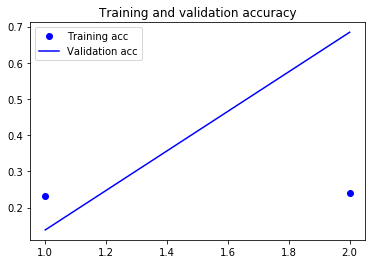

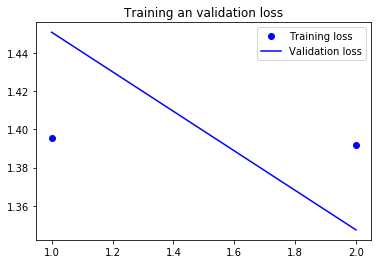

In [49]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b',label = 'Validation loss')
plt.title('Training an validation loss')
plt.legend()

plt.show()

## Appendix

In [55]:
import tensorflow as tf
import numpy as np

from tacotron import create_model, get_most_recent_checkpoint
from hparams import hparams
from text import text_to_sequence, sequence_to_text

def _pad_input(x, length):
    return np.pad(x, (0, length - x.shape[0]), mode='constant', constant_values=0)

def _prepare_inputs(inputs):  # inputs: batch 길이 만큼의 list
    max_len = max((len(x) for x in inputs))
    return np.stack([_pad_input(x, max_len) for x in inputs])  # (batch_size, max_len)
    """
    batch_size = 2 일 떼,
    [[13, 26, 13, 41, 13, 21, 13, 41, 13, 21, 13, 41,  9, 41, 13, 40,79, 14, 34, 13, 33, 79, 20, 32, 13, 35, 45,  2, 34, 42, 13, 39,7, 29, 11, 25,  1],
    [ 6, 29, 79, 14, 26, 14, 34,  5, 29, 79,  2, 30, 45,  2, 28, 14,21, 79, 13, 27,  7, 25,  9, 34, 45, 13, 40, 79,  4, 29,  2, 29,13, 26,  1,  0,  0]]    
    """
    
num_speakers = 1
speaker_ids = [0]

checkpoint_path = get_most_recent_checkpoint("Trained_model")

inputs = tf.placeholder(tf.int32, [None, None], 'inputs')
input_lengths = tf.placeholder(tf.int32, [None], 'input_lengths')

batch_size = tf.shape(inputs)[0]
speaker_id = tf.placeholder_with_default(
            tf.zeros([batch_size], dtype=tf.int32), [None], 'speaker_id')


with tf.variable_scope('model') as scope:
    model = create_model(hparams)
    model.initialize(inputs, input_lengths, num_speakers, speaker_id,rnn_decoder_test_mode=True)
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

#input example
texts = "오스트랄로피테쿠스 아파렌시스는 멸종된 사람족 종으로"
if type(texts) == str:
    texts = [texts]
    
sequences = np.array([text_to_sequence(text) for text in texts])
sequences = _prepare_inputs(sequences)

input_lengths = [np.argmax(a==1)+1 for a in sequences]

feed_dict = { model.inputs: sequences, model.input_lengths: input_lengths, }
feed_dict[model.speaker_id] = speaker_ids

encoder_out = sess.run(model.encoder_outputs,feed_dict=feed_dict)

print (encoder_out)

sess.close()

 [*] Found lastest checkpoint: Trained_model/model.ckpt-200000
 model_type: single
Initialized Tacotron model. Dimensions: 
    embedding:                256
    speaker embedding:        None
    prenet out:               128
    encoder out:              256
    attention out:            256
    concat attn & out:        512
    decoder cell out:         256
    decoder out (5 frames):  400
    decoder out (1 frame):    80
    postnet out:              256
    linear out:               1025
INFO:tensorflow:Restoring parameters from Trained_model/model.ckpt-200000
[[[ 0.0000000e+00  9.6732837e-01 -9.8763037e-01 ... -9.9943042e-01
   -9.8349977e-01  8.9600855e-01]
  [-1.1051817e-05  9.0454382e-01 -5.8325720e-01 ... -9.4815683e-01
   -2.8077272e-01  8.9162952e-01]
  [-1.0525452e-04  8.8934141e-01  9.9772209e-01 ...  1.1586651e-02
   -2.3645875e-01  4.1550836e-01]
  ...
  [ 5.9382367e-01  3.0472282e-01 -5.2274424e-01 ...  4.1635299e-01
   -1.5526828e-01 -6.7680061e-01]
  [ 6.2266862e-01 

In [56]:
input_lengths

[62]

In [81]:
tf.reset_default_graph()